# Financial News Sentiment Analysis with FinBERT

**Goal:** To perform a comprehensive analysis of financial news headlines, select the best sentiment model, and process the headlines into a daily sentiment score for a specific stock. This structured sentiment data will then be used as a feature in our stock prediction model in Part 2.

**Workflow:**
1.  **Setup & Data Loading:** Load and combine news data from multiple sources.
2.  **Exploratory Data Analysis (EDA):** Visualize word frequencies and headline characteristics.
3.  **Model Evaluation:** Qualitatively compare a finance-specific model (FinBERT) against a generic model.
4.  **Sentiment Calculation:** Use the superior model (FinBERT) to process all headlines and generate daily scores.
5.  **Live Testing:** Create a function to test the model on custom sentences.
6.  **Save Results:** Export the daily sentiment scores to a CSV file for use in Part 2.

In [1]:
# 1. Imports and Setup

import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm.notebook import tqdm
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')

print("All libraries imported successfully.")

All libraries imported successfully.


## 2. Load and Prepare the News Dataset

We'll load headlines from both `raw_analyst_ratings.csv` and `raw_partner_headlines.csv` to create a comprehensive news dataset. We will then filter for our target stock, **Apple (AAPL)**.

In [2]:
# Load both headline datasets
try:
    df_ratings = pd.read_csv('raw_analyst_ratings.csv')
    df_partner = pd.read_csv('raw_partner_headlines.csv')
    print(f"Loaded {len(df_ratings)} headlines from analyst ratings.")
    print(f"Loaded {len(df_partner)} headlines from partner news.")
except FileNotFoundError:
    print("Make sure 'raw_analyst_ratings.csv' and 'raw_partner_headlines.csv' are in the same directory.")
    # Create empty dataframes to prevent further errors if files are not found
    df_ratings = pd.DataFrame(columns=['headline', 'date', 'stock'])
    df_partner = pd.DataFrame(columns=['headline', 'date', 'stock'])

# --- Standardize and Combine ---
ratings_headlines = df_ratings[['headline', 'date', 'stock']].copy()
partner_headlines = df_partner[['headline', 'date', 'stock']].copy()
df_all_news = pd.concat([ratings_headlines, partner_headlines], ignore_index=True)
df_all_news.dropna(subset=['headline'], inplace=True)
df_all_news.drop_duplicates(subset=['headline'], inplace=True)

print(f"\nTotal unique headlines combined: {len(df_all_news)}")

# --- Configuration ---
TICKER = "AAPL"
# --------------------

# Filter for the specific ticker
df_aapl = df_all_news[df_all_news['stock'] == TICKER].copy()

# Correctly parse the mixed-format date column and extract the date part
df_aapl['date'] = pd.to_datetime(df_aapl['date'], format='mixed', utc=True).dt.date
df_aapl = df_aapl.rename(columns={'headline': 'title'})

print(f"\nFiltered for {TICKER}. Found {len(df_aapl)} news headlines.")
df_aapl[['date', 'title']].head()

Loaded 1407328 headlines from analyst ratings.
Loaded 1845559 headlines from partner news.

Total unique headlines combined: 1649972

Filtered for AAPL. Found 453 news headlines.


,date,title
6680,2020-06-10,Tech Stocks And FAANGS Strong Again To Start D...
6682,2020-06-10,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,..."
6683,2020-06-10,"Deutsche Bank Maintains Buy on Apple, Raises P..."
6684,2020-06-10,Apple To Let Users Trade In Their Mac Computer...
6685,2020-06-10,Big Tech Reaches New Record Heights At The Sto...


## 3. Exploratory Data Analysis (EDA) on Headlines

Let's visualize the text data to understand common themes and characteristics.

Most Common Words in AAPL Headlines:


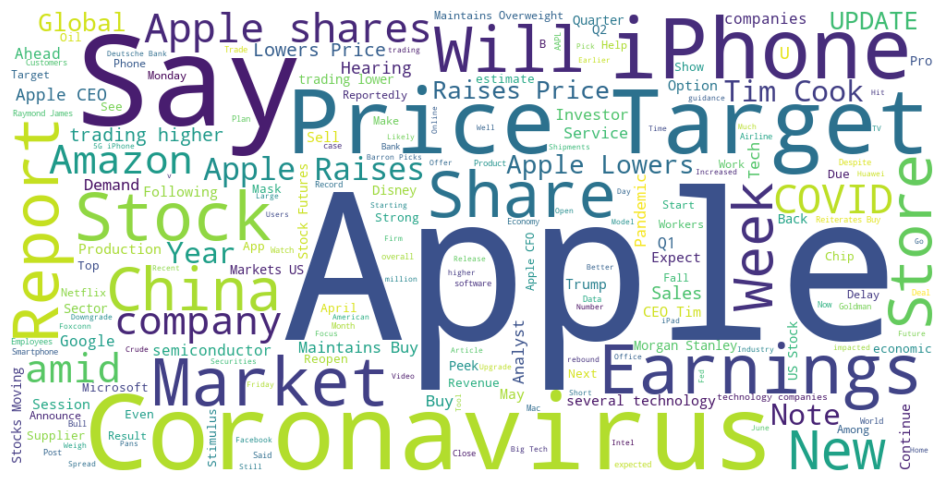

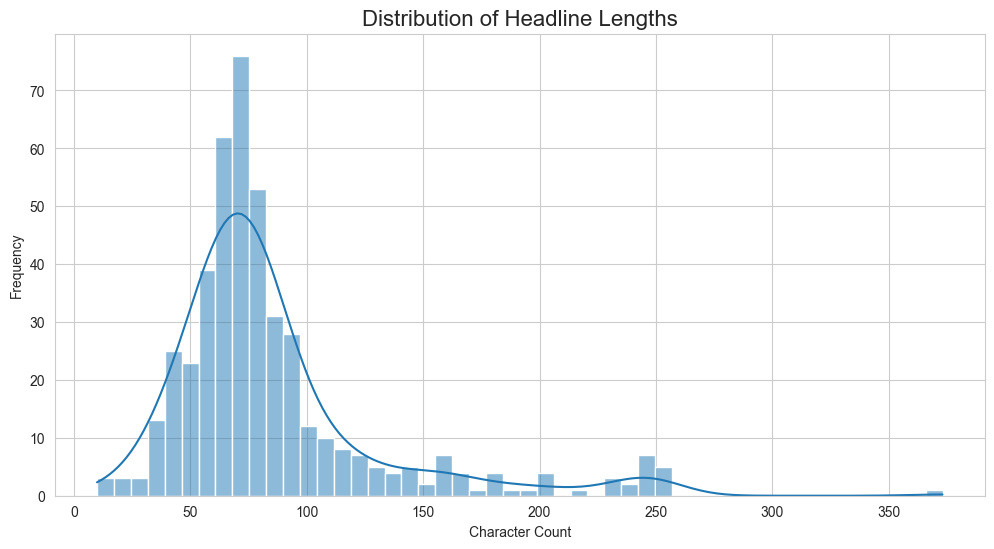

In [3]:
# --- Word Cloud ---
text = " ".join(title for title in df_aapl.title)
wordcloud = WordCloud(width=1000, height=500, background_color="white", colormap="viridis").generate(text)

print("Most Common Words in AAPL Headlines:")
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# --- Headline Length Distribution ---
df_aapl['headline_length'] = df_aapl['title'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(df_aapl['headline_length'], bins=50, kde=True)
plt.title('Distribution of Headline Lengths', fontsize=16)
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

## 4. Model Comparison for Qualitative Evaluation

To prove that a finance-specific model is the right choice, we will compare **FinBERT** against a generic sentiment model trained on Twitter data. We'll test them on a few sample financial sentences.

In [6]:
# Load the finance-specific model (FinBERT)
finbert_model_name = "ProsusAI/finbert"
finbert_pipeline = pipeline("sentiment-analysis", model=finbert_model_name, tokenizer=finbert_model_name, device=-1)

# Load a generic sentiment model for comparison
generic_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
generic_pipeline = pipeline("sentiment-analysis", model=generic_model_name, tokenizer=generic_model_name, device=-1)

# --- Create a list of test sentences ---
test_headlines = [
    "AAPL earnings beat analyst expectations, sending the stock soaring.", # Clearly Positive
    "Apple faces new regulatory scrutiny over App Store policies.",      # Clearly Negative
    "Analysts are divided on the upcoming iPhone release.",             # Clearly Neutral/Mixed
    "The company announced a quarterly dividend for shareholders.",       # Financially positive, but neutral tone
]

# --- Compare the outputs ---
results = []
for text in test_headlines:
    finbert_result = finbert_pipeline(text)[0]
    generic_result = generic_pipeline(text)[0]
    results.append({
        "Headline": text,
        "FinBERT Prediction": finbert_result['label'].upper(),
        "Generic RoBERTa Prediction": generic_result['label'].upper()
    })

df_comparison = pd.DataFrame(results)
print("--- Model Comparison on Sample Headlines ---")
display(df_comparison)

# Conclusion: We will proceed with FinBERT as it's specialized for this domain.
sentiment_pipeline = finbert_pipeline
model = finbert_pipeline.model
tokenizer = finbert_pipeline.tokenizer

/Users/akshaiasai/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeq

--- Model Comparison on Sample Headlines ---


,Headline,FinBERT Prediction,Generic RoBERTa Prediction
0,"AAPL earnings beat analyst expectations, sendi...",POSITIVE,POSITIVE
1,Apple faces new regulatory scrutiny over App S...,NEGATIVE,NEUTRAL
2,Analysts are divided on the upcoming iPhone re...,NEGATIVE,NEUTRAL
3,The company announced a quarterly dividend for...,NEUTRAL,NEUTRAL


## 5. Calculate Daily Sentiment Scores with FinBERT

Now, using our chosen FinBERT model, we'll process all the AAPL headlines. We will group headlines by date and calculate a single, average sentiment score for each day. This is a computationally intensive step.

**Score Calculation:** `(Probability of 'positive') - (Probability of 'negative')`

In [7]:
# Group headlines by date for processing
grouped_headlines = df_aapl.groupby('date')['title'].apply(list)
daily_sentiments = {}

# Use tqdm for a progress bar
for date, headlines in tqdm(grouped_headlines.items(), desc="Analyzing daily sentiment"):
    scores = []
    for headline in headlines:
        inputs = tokenizer(headline, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits
        
        probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
        # FinBERT label order is [positive, negative, neutral]
        pos_prob, neg_prob = probabilities[0].item(), probabilities[1].item()
        
        score = pos_prob - neg_prob
        scores.append(score)
    
    if scores:
        daily_sentiments[date] = np.mean(scores)

print(f"\nSentiment analysis complete for {len(daily_sentiments)} days.")

# Convert the results to a DataFrame for saving
df_sentiment = pd.DataFrame(daily_sentiments.items(), columns=['date', 'sentiment_score'])
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment = df_sentiment.set_index('date').sort_index()

print("\nDaily sentiment scores calculated successfully:")
df_sentiment.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Analyzing daily sentiment: 0it [00:00, ?it/s]


Sentiment analysis complete for 81 days.

Daily sentiment scores calculated successfully:


,sentiment_score
date,
2020-03-09,-0.365338
2020-03-10,-0.378180
2020-03-11,-0.262767
2020-03-12,-0.062725
2020-03-13,0.097736


## 6. Save the Processed Sentiment Data

We save the calculated daily scores to a new CSV file. This file is the final output of Part 1 and will be the input for Part 2.

In [8]:
# Save the results to a CSV
output_filename = f'{TICKER}_daily_sentiment.csv'
df_sentiment.to_csv(output_filename)

print(f"Daily sentiment scores saved to '{output_filename}'. This file is now ready for Notebook 2.")

Daily sentiment scores saved to 'AAPL_daily_sentiment.csv'. This file is now ready for Notebook 2.


## 7. Test the Sentiment Model on a Custom Input
Here's a simple function to test our FinBERT model on any sentence we provide. This is useful for interactive testing and demonstration.

In [9]:
def analyze_sentiment(text):
    """
    Analyzes a single piece of text using the loaded FinBERT pipeline
    and prints a formatted result.
    """
    result = sentiment_pipeline(text)[0]
    
    print(f"Input Text: '{text}'")
    print(f"Predicted Sentiment: {result['label'].upper()}")
    print(f"Confidence Score: {result['score']:.2%}")
    
    # Detailed Score Breakdown
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
    
    print("\n--- Score Breakdown ---")
    print(f"Positive: {probabilities[0].item():.2%}")
    print(f"Negative: {probabilities[1].item():.2%}")
    print(f"Neutral:  {probabilities[2].item():.2%}")

# --- Test with your own sentences! ---
my_headline = "Apple announces record-breaking profits and a new stock buyback program."
analyze_sentiment(my_headline)

print("\n" + "="*50 + "\n")

my_headline_2 = "The company is facing production delays and supply chain issues."
analyze_sentiment(my_headline_2)

Input Text: 'Apple announces record-breaking profits and a new stock buyback program.'
Predicted Sentiment: NEUTRAL
Confidence Score: 64.39%

--- Score Breakdown ---
Positive: 30.25%
Negative: 5.36%
Neutral:  64.39%


Input Text: 'The company is facing production delays and supply chain issues.'
Predicted Sentiment: NEGATIVE
Confidence Score: 96.22%

--- Score Breakdown ---
Positive: 0.79%
Negative: 96.22%
Neutral:  2.99%
